### 파이썬 라이브러리를 Import합니다.

In [1]:
# ==============================================================================
# 1. 표준 라이브러리 (Standard Library)
# ==============================================================================
import os
import re
import math
import random
import shutil
import glob
import unicodedata
import xml.etree.ElementTree as ET
import importlib
from pathlib import Path
from datetime import datetime, timedelta
from typing import List, Dict, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

# ==============================================================================
# 2. 서드파티 라이브러리 (Third-party Libraries)
# ==============================================================================
import subprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch

# Scikit-learn 및 PyTorch 관련
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader

# NLTK 및 자연어 처리 (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# ==============================================================================
# 3. NLTK 데이터 다운로드 및 설정
# ==============================================================================
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

assert os.path.exists('cbow_data.py'), "cbow_data.py 파일이 없습니다."
assert os.path.exists('cbow_model.py'), "cbow_model.py 파일이 없습니다."
assert os.path.exists('cbow_trainer.py'), "cbow_trainer.py 파일이 없습니다."
assert os.path.exists('skip_gram_data.py'), "skip_gram_data.py 파일이 없습니다."
assert os.path.exists('skip_gram_model.py'), "skip_gram_model.py 파일이 없습니다."
assert os.path.exists('skip_gram_trainer.py'), "skip_gram_trainer.py 파일이 없습니다."

from cbow_data import LemmaCBOWDataModule
from cbow_model import CBOW
from cbow_trainer import Word2VecTrainer
from skip_gram_data import LemmaSkipGramDataModule
from skip_gram_model import SkipGram
from skip_gram_trainer import SkipGramTrainer


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bmegpu03/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bmegpu03/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/bmegpu03/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Using device: cuda


In [2]:
file_path = '/home/bmegpu03/nlp/pubmed_dataset_250901-250915.gzip'
df_preprocessed = pd.read_parquet(file_path)
df_preprocessed

,title,abstract,path,pmid,tokens,tokens_no_stop,stems,lemmas,n_tokens,n_tokens_nostop
pmcid,,,,,,,,,,
PMC12423219,Gigantomastia: Advancing a Preference Score Sy...,BackgroundThis study introduces a new Gigantom...,./recent_pubmed/PMC12423219.xml,40180643,"[backgroundthis, study, introduces, a, new, gi...","[backgroundthis, introduces, new, gigantomasti...","[backgroundthi, introduc, new, gigantomastia, ...","[backgroundthis, introduces, new, gigantomasti...",219,140
PMC12410828,Infective Endocarditis Presenting as Unexplain...,Infective endocarditis is a potentially fatal ...,./recent_pubmed/PMC12410828.xml,None,"[infective, endocarditis, is, a, potentially, ...","[infective, endocarditis, potentially, fatal, ...","[infect, endocard, potenti, fatal, condit, pre...","[infective, endocarditis, potentially, fatal, ...",203,143
PMC12423464,“Eating isn’t just about paying attention—It's...,Background: Recent research has focused on sev...,./recent_pubmed/PMC12423464.xml,39397561,"[background, recent, research, has, focused, o...","[recent, research, focused, several, critical,...","[recent, research, focus, sever, critic, categ...","[recent, research, focused, several, critical,...",257,158
PMC12417792,Yield of next-generation sequencing in diagnos...,Background and study aimsThis study addressed ...,./recent_pubmed/PMC12417792.xml,None,"[background, and, study, aimsthis, study, addr...","[aimsthis, addressed, need, improved, diagnost...","[aimsthi, address, need, improv, diagnost, too...","[aimsthis, addressed, need, improved, diagnost...",267,160
PMC12430085,Oncologists’ Perspectives on Ketogenic Diets i...,Background/objectives: Treating pediatric brai...,./recent_pubmed/PMC12430085.xml,None,"[treating, pediatric, brain, tumors, remains, ...","[treating, pediatric, brain, tumors, remains, ...","[treat, pediatr, brain, tumor, remain, challen...","[treating, pediatric, brain, tumor, remains, c...",248,168
...,...,...,...,...,...,...,...,...,...,...
PMC12422480,An updated vocal repertoire of wild adult bono...,Research over the last 20 years has shed impor...,./recent_pubmed/PMC12422480.xml,40929072,"[research, over, the, last, 20, years, has, sh...","[research, last, 20, years, shed, important, l...","[research, last, 20, year, shed, import, light...","[research, last, 20, year, shed, important, li...",140,90
PMC12426568,Supporting Police Well-Being Through an Adapti...,BackgroundPolice personnel work under challeng...,./recent_pubmed/PMC12426568.xml,40875980,"[backgroundpolice, personnel, work, under, cha...","[backgroundpolice, personnel, work, challengin...","[backgroundpolic, personnel, work, challeng, c...","[backgroundpolice, personnel, work, challengin...",399,270
PMC12423179,Association Between Self-Reported Opioid Use a...,BackgroundArizona observed a sharp increase in...,./recent_pubmed/PMC12423179.xml,None,"[backgroundarizona, observed, a, sharp, increa...","[backgroundarizona, observed, sharp, increase,...","[backgroundarizona, observ, sharp, increas, op...","[backgroundarizona, observed, sharp, increase,...",195,127


## CBOW

Using device: cuda

--- CBOW 모델 학습 시작 ---

[Step 1] 데이터 모듈 초기화 중...
Initializing DataModule...
Building vocabulary...
Vocabulary built. Total size: 67685
------------------------------
Creating Train Dataset...
Creating CBOW samples with window_size=2...
Total 2,632,317 samples created.
Creating Valid Dataset...
Creating CBOW samples with window_size=2...
Total 155,392 samples created.
Creating Test Dataset...
Creating CBOW samples with window_size=2...
Total 346,427 samples created.
------------------------------
DataModule initialized.
Vocab size: 67685
#Train samples: 2,632,317
#Valid samples: 155,392
#Test  samples: 346,427
데이터 모듈 준비 완료.

[Step 2] CBOW 모델 초기화 중...
모델 준비 완료.

[Step 3] 트레이너 초기화 중...
트레이너 준비 완료.

[Step 4] 모델 학습 시작...
Start training on cuda...
Best model will be saved to: best_cbow_model.pth

Epoch 1/50


  ▶ Train Loss: 8.7264 | Train Acc: 0.0348
  ▶ Valid Loss: 8.1397 | Valid Acc: 0.0529
  ▶ Valid loss improved. Saving best model to best_cbow_model.pth

Epoch 2/50


  ▶ Train Loss: 7.6449 | Train Acc: 0.0598
  ▶ Valid Loss: 7.7780 | Valid Acc: 0.0678
  ▶ Valid loss improved. Saving best model to best_cbow_model.pth

Epoch 3/50


  ▶ Train Loss: 7.1903 | Train Acc: 0.0722
  ▶ Valid Loss: 7.6116 | Valid Acc: 0.0750
  ▶ Valid loss improved. Saving best model to best_cbow_model.pth

Epoch 4/50


  ▶ Train Loss: 6.8814 | Train Acc: 0.0819
  ▶ Valid Loss: 7.5233 | Valid Acc: 0.0795
  ▶ Valid loss improved. Saving best model to best_cbow_model.pth

Epoch 5/50


  ▶ Train Loss: 6.6496 | Train Acc: 0.0907
  ▶ Valid Loss: 7.4748 | Valid Acc: 0.0829
  ▶ Valid loss improved. Saving best model to best_cbow_model.pth

Epoch 6/50


  ▶ Train Loss: 6.4664 | Train Acc: 0.0989
  ▶ Valid Loss: 7.4497 | Valid Acc: 0.0847
  ▶ Valid loss improved. Saving best model to best_cbow_model.pth

Epoch 7/50


  ▶ Train Loss: 6.3184 | Train Acc: 0.1071
  ▶ Valid Loss: 7.4376 | Valid Acc: 0.0864
  ▶ Valid loss improved. Saving best model to best_cbow_model.pth

Epoch 8/50


  ▶ Train Loss: 6.1953 | Train Acc: 0.1148
  ▶ Valid Loss: 7.4335 | Valid Acc: 0.0883
  ▶ Valid loss improved. Saving best model to best_cbow_model.pth

Epoch 9/50


  ▶ Train Loss: 6.0908 | Train Acc: 0.1222
  ▶ Valid Loss: 7.4351 | Valid Acc: 0.0898
  ▶ Early stopping counter: 1/5

Epoch 10/50


  ▶ Train Loss: 5.9998 | Train Acc: 0.1287
  ▶ Valid Loss: 7.4414 | Valid Acc: 0.0907
  ▶ Early stopping counter: 2/5

Epoch 11/50


  ▶ Train Loss: 5.9210 | Train Acc: 0.1351
  ▶ Valid Loss: 7.4480 | Valid Acc: 0.0915
  ▶ Early stopping counter: 3/5

Epoch 12/50


  ▶ Train Loss: 5.8505 | Train Acc: 0.1404
  ▶ Valid Loss: 7.4568 | Valid Acc: 0.0921
  ▶ Early stopping counter: 4/5

Epoch 13/50


  ▶ Train Loss: 5.7854 | Train Acc: 0.1458
  ▶ Valid Loss: 7.4661 | Valid Acc: 0.0925
  ▶ Early stopping counter: 5/5
Early stopping triggered after 5 epochs without improvement.

Training complete.

[Step 5] 학습 로그 시각화...


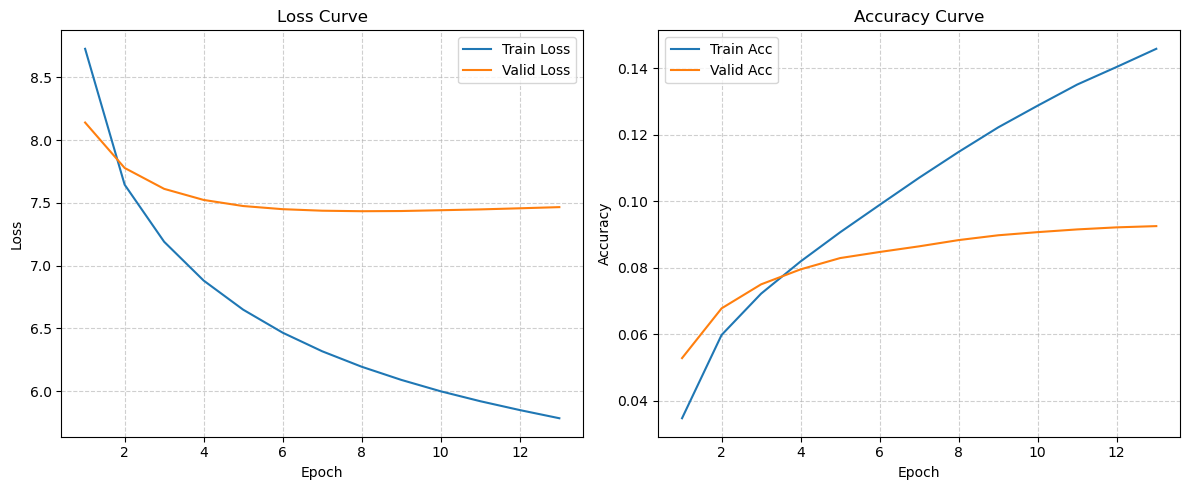

/home/bmegpu03/nlp/cbow_trainer.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.save_path, map_location=self.device))



[Step 6] Best Model로 테스트 수행...

Loaded best model from best_cbow_model.pth for testing.



Test Result ▶ Loss: 7.4991 | Acc: 0.0877

--- 모든 CBOW 학습 과정 완료 ---


In [ ]:
print("\n--- CBOW 모델 학습 시작 ---")
torch.cuda.empty_cache()

try:
    # 1) 데이터 준비
    print("\n[Step 1] 데이터 모듈 초기화 중...")
    cbow_datamodule = LemmaCBOWDataModule(
        df_all=df_preprocessed,
        batch_size=4096,     # (GPU 메모리에 맞춰 조절)
        window_size=2,
        min_freq=2,          
        max_vocab=None,
        max_samples_per_doc=None,
        device=DEVICE
    )
    
    cbow_train_loader = cbow_datamodule.get_train_loader(num_workers=4)
    cbow_valid_loader = cbow_datamodule.get_valid_loader(num_workers=4)
    cbow_test_loader  = cbow_datamodule.get_test_loader(num_workers=4)
    print("데이터 모듈 준비 완료.")

    # 2) 모델 준비
    print("\n[Step 2] CBOW 모델 초기화 중...")
    model_args = {
        'vocab_size':  cbow_datamodule.vocab_size,
        'embed_dim':   128,
        'padding_idx': cbow_datamodule.stoi['<pad>'], # (pad 인덱스 명시)
        'dropout_p':   0.2,
    }
    cbow_model = CBOW(**model_args)
    print("모델 준비 완료.")
    
    # 3) 학습 트레이너 준비 (Early Stopping 사용)
    print("\n[Step 3] 트레이너 초기화 중...")
    cbow_trainer = Word2VecTrainer(
        learning_rate=2e-3,
        weight_decay=1e-5,
        num_epochs=50,       # (최대 50 에폭, 그 전에 Early Stop 가능)
        patience=5,         # (5 에폭 동안 valid loss 개선 없으면 중단)
        save_path='best_cbow_model.pth', # (Best Model 저장 경로)
        device=DEVICE
    )
    print("트레이너 준비 완료.")

    # 4) 학습/검증 진행
    print("\n[Step 4] 모델 학습 시작...")
    cbow_trainer.train(cbow_model, cbow_train_loader, cbow_valid_loader)

    # 5) 학습 로그 시각화
    print("\n[Step 5] 학습 로그 시각화...")
    cbow_trainer.plot_logs()

    # 6) 테스트 (저장된 Best Model로 테스트)
    print("\n[Step 6] Best Model로 테스트 수행...")
    cbow_trainer.test(cbow_model, cbow_test_loader)

    print("\n--- 모든 CBOW 학습 과정 완료 ---")

except Exception as e:
    print(f"\n[오류 발생] CBOW 학습 중단: {e}")
    # (오류 발생 시에도 CUDA 캐시 정리)
    torch.cuda.empty_cache()

## Skip-gram


--- Skip-Gram 모델 학습 시작 ---

[Step 1] Skip-Gram 데이터 모듈 초기화 중...
Initializing Skip-Gram DataModule...
Building vocabulary...
Vocabulary built. Total size: 67685
Calculating weights for Negative Sampling...
------------------------------
Creating Train Dataset...
Creating Skip-Gram positive pairs with window_size=2...
Total 10,707,734 positive pairs created.
Creating Valid Dataset...
Creating Skip-Gram positive pairs with window_size=2...
Total 632,180 positive pairs created.
Creating Test Dataset...
Creating Skip-Gram positive pairs with window_size=2...
Total 1,406,640 positive pairs created.
------------------------------
DataModule initialized.
Vocab size (Skip-Gram): 67685
#Train samples (pos pairs): 10,707,734
#Valid samples (pos pairs): 632,180
#Test  samples (pos pairs): 1,406,640
데이터 모듈 준비 완료.

[Step 2] Skip-Gram 모델 초기화 중...
모델 준비 완료.

[Step 3] 트레이너 초기화 중...
트레이너 준비 완료.

[Step 4] 모델 학습 시작...

Start training on cuda...
Best model will be saved to: best_skipgram_model.pth

Epoch 1

   ▶ Train Loss: 6.9003
   ▶ Valid Loss: 5.2935
New best model saved to best_skipgram_model.pth (Valid Loss: 5.2935)

Epoch 2/50


   ▶ Train Loss: 4.0794
   ▶ Valid Loss: 3.5055
New best model saved to best_skipgram_model.pth (Valid Loss: 3.5055)

Epoch 3/50


   ▶ Train Loss: 2.7521
   ▶ Valid Loss: 2.6545
New best model saved to best_skipgram_model.pth (Valid Loss: 2.6545)

Epoch 4/50


   ▶ Train Loss: 2.1039
   ▶ Valid Loss: 2.2056
New best model saved to best_skipgram_model.pth (Valid Loss: 2.2056)

Epoch 5/50


   ▶ Train Loss: 1.7385
   ▶ Valid Loss: 1.9403
New best model saved to best_skipgram_model.pth (Valid Loss: 1.9403)

Epoch 6/50


   ▶ Train Loss: 1.5094
   ▶ Valid Loss: 1.7841
New best model saved to best_skipgram_model.pth (Valid Loss: 1.7841)

Epoch 7/50


   ▶ Train Loss: 1.3577
   ▶ Valid Loss: 1.6898
New best model saved to best_skipgram_model.pth (Valid Loss: 1.6898)

Epoch 8/50


   ▶ Train Loss: 1.2504
   ▶ Valid Loss: 1.6317
New best model saved to best_skipgram_model.pth (Valid Loss: 1.6317)

Epoch 9/50


   ▶ Train Loss: 1.1704
   ▶ Valid Loss: 1.5968
New best model saved to best_skipgram_model.pth (Valid Loss: 1.5968)

Epoch 10/50


   ▶ Train Loss: 1.1095
   ▶ Valid Loss: 1.5807
New best model saved to best_skipgram_model.pth (Valid Loss: 1.5807)

Epoch 11/50


   ▶ Train Loss: 1.0625
   ▶ Valid Loss: 1.5765
New best model saved to best_skipgram_model.pth (Valid Loss: 1.5765)

Epoch 12/50


   ▶ Train Loss: 1.0250
   ▶ Valid Loss: 1.5803
No improvement in validation loss for 1 epoch(s).

Epoch 13/50


   ▶ Train Loss: 0.9943
   ▶ Valid Loss: 1.5915
No improvement in validation loss for 2 epoch(s).

Epoch 14/50


   ▶ Train Loss: 0.9692
   ▶ Valid Loss: 1.6079
No improvement in validation loss for 3 epoch(s).

Epoch 15/50


   ▶ Train Loss: 0.9474
   ▶ Valid Loss: 1.6283
No improvement in validation loss for 4 epoch(s).

Epoch 16/50


   ▶ Train Loss: 0.9290
   ▶ Valid Loss: 1.6492
No improvement in validation loss for 5 epoch(s).

Early stopping triggered after 16 epochs.

Training complete.

[Step 5] 학습 로그 시각화...


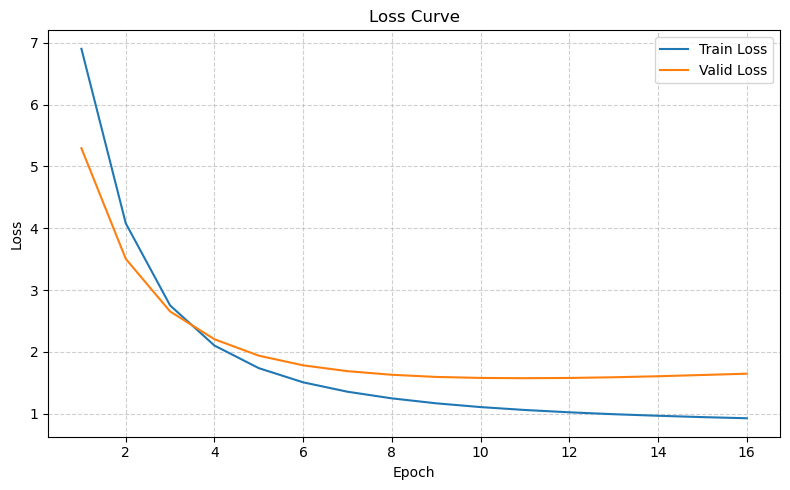

/home/bmegpu03/nlp/skip_gram_trainer.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.save_path, map_location=self.device))



[Step 6] Best Model로 테스트 수행...

Loaded best model from best_skipgram_model.pth for testing.



Test Result ▶ Loss: 1.6038

--- 모든 Skip-Gram 학습 과정 완료 ---


In [12]:
print("\n--- Skip-Gram 모델 학습 시작 ---")
torch.cuda.empty_cache()

try:
    # 1) 데이터 준비 (sg_... 접두사 사용)
    print("\n[Step 1] Skip-Gram 데이터 모듈 초기화 중...")
    sg_datamodule = LemmaSkipGramDataModule(
        df_all=df_preprocessed,
        batch_size=4096,     
        window_size=2,
        min_freq=2,
        max_vocab=None,
        max_samples_per_doc=None,
        num_neg_samples=5      # Negative 샘플 개수
    )
    
    # (num_workers=0 : CPU 텐서 반환 시 가장 안정적)
    sg_train_loader = sg_datamodule.get_train_loader(num_workers=4, pin_memory=True)
    sg_valid_loader = sg_datamodule.get_valid_loader(num_workers=4, pin_memory=True)
    sg_test_loader  = sg_datamodule.get_test_loader(num_workers=4, pin_memory=True)
    print("데이터 모듈 준비 완료.")

    # 2) 모델 준비
    print("\n[Step 2] Skip-Gram 모델 초기화 중...")
    sg_model_args = {
        'vocab_size':  sg_datamodule.vocab_size,
        'embed_dim':   128,
        'padding_idx': sg_datamodule.stoi['<pad>'],
    }
    sg_model = SkipGram(**sg_model_args)
    print("모델 준비 완료.")
    
    # 3) 학습 트레이너 준비 (SkipGramTrainer 사용)
    print("\n[Step 3] 트레이너 초기화 중...")
    sg_trainer = SkipGramTrainer(
        learning_rate=1e-3,  # (Skip-Gram은 더 낮은 LR이 안정적일 수 있음)
        weight_decay=1e-5,
        num_epochs=50,       # (최대 50 에폭)
        patience=5,          # (요청하신 5)
        save_path='best_skipgram_model.pth', # (저장 경로)
        device=DEVICE
    )
    print("트레이너 준비 완료.")

    # 4) 학습/검증 진행
    print("\n[Step 4] 모델 학습 시작...")
    sg_trainer.train(sg_model, sg_train_loader, sg_valid_loader)

    # 5) 학습 로그 시각화
    print("\n[Step 5] 학습 로그 시각화...")
    sg_trainer.plot_logs()

    # 6) 테스트 (저장된 Best Model로 테스트)
    print("\n[Step 6] Best Model로 테스트 수행...")
    sg_trainer.test(sg_model, sg_test_loader)

    print("\n--- 모든 Skip-Gram 학습 과정 완료 ---")

except Exception as e:
    print(f"\n[오류 발생] Skip-Gram 학습 중단: {e}")
    # (오류 발생 시에도 CUDA 캐시 정리)
    torch.cuda.empty_cache()


## 모델 정성 분석을 진행합니다.

In [3]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def _ensure_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def visualize_embedding_heatmap(itos, emb_matrix, target_tokens=None, top_k=None, exclude_pad_idx=0, title="Word Embeddings"):
    """
    A) 단어 임베딩 값 히트맵 (행=단어, 열=임베딩 차원)
    - target_tokens: 시각화할 토큰 리스트 (예: ['cell','protein','gene',...])
    - top_k: target_tokens를 주지 않으면, 사전 앞쪽에서 top_k개를 사용(패딩 제외)
    """
    E = _ensure_numpy(emb_matrix)     # (V, D)
    V, D = E.shape
    # itos: dict {idx:int -> token:str}
    stoi = {tok: idx for idx, tok in itos.items()}

    # 대상 인덱스 선택
    if target_tokens:
        idxs = [stoi[tok] for tok in target_tokens if tok in stoi]
        labels = [itos[i] for i in idxs]
    else:
        # PAD(0) 같은 특수 토큰 제외하고 상위 몇 개
        candidates = [i for i in range(V) if i != exclude_pad_idx]
        if top_k is None:
            top_k = min(30, len(candidates))
        idxs = candidates[:top_k]
        labels = [itos[i] for i in idxs]

    mat = E[idxs]  # (N, D)

    # 정규화(선택): 각 단어 벡터 z-score → 차원별 스케일 차 완화
    mat_norm = (mat - mat.mean(axis=1, keepdims=True)) / (mat.std(axis=1, keepdims=True) + 1e-8)

    df = pd.DataFrame(mat_norm, index=labels, columns=[f"d{j}" for j in range(D)])

    plt.figure(figsize=(df.shape[0]*1.1, df.shape[1]*1.1))
    sns.heatmap(df, cmap="vlag", center=0, square=True, cbar=False)
    plt.title(title)
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Token")
    plt.tight_layout()

과제 3단계: 정성적 비교 분석 시작...
--- 1. CBOW 모델 로드 중 ---
Initializing DataModule...
Building vocabulary...
Vocabulary built. Total size: 67685
------------------------------
Creating Train Dataset...
Creating CBOW samples with window_size=2...
Total 2,632,317 samples created.
Creating Valid Dataset...
Creating CBOW samples with window_size=2...
Total 155,392 samples created.
Creating Test Dataset...
Creating CBOW samples with window_size=2...
Total 346,427 samples created.
------------------------------
DataModule initialized.
Vocab size: 67685
#Train samples: 2,632,317
#Valid samples: 155,392
#Test  samples: 346,427


/tmp/ipykernel_397234/4059182408.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cbow_model.load_state_dict(torch.load('best_cbow_model.pth'))


CBOW 모델('best_cbow_model.pth') 로드 성공.


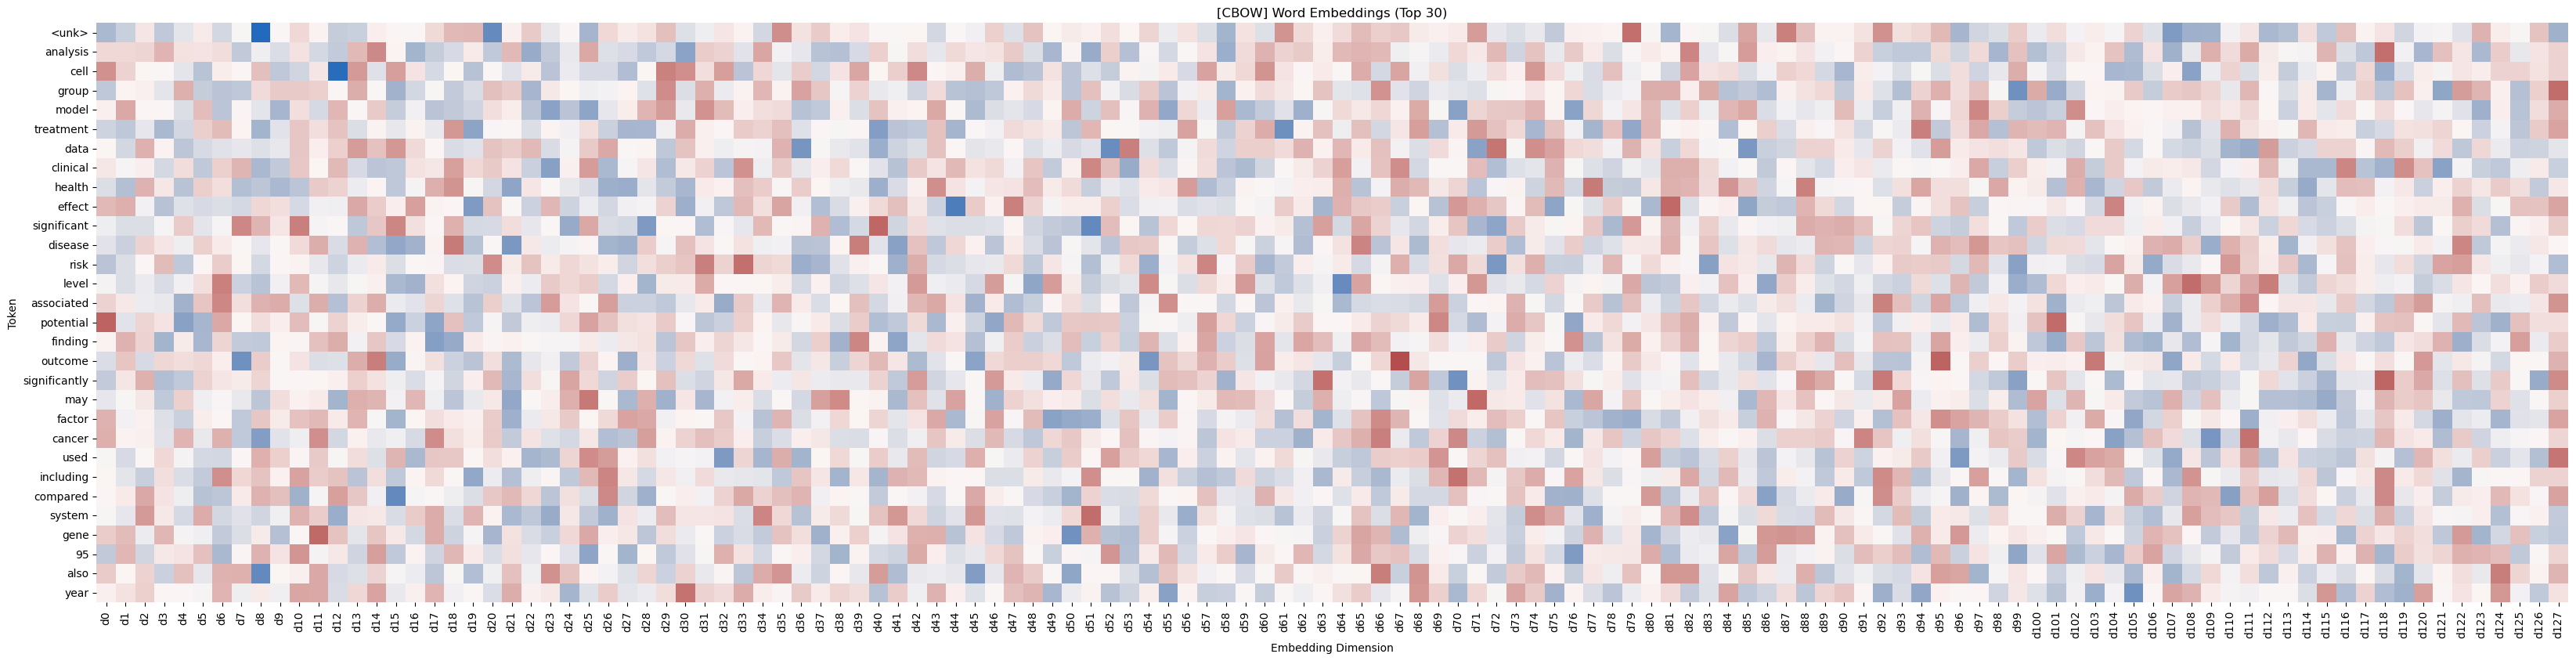


--- 2. Skip-Gram 모델 로드 중 ---
Initializing Skip-Gram DataModule...
Building vocabulary...
Vocabulary built. Total size: 67685
Calculating weights for Negative Sampling...
------------------------------
Creating Train Dataset...
Creating Skip-Gram positive pairs with window_size=2...
Total 10,707,734 positive pairs created.
Creating Valid Dataset...
Creating Skip-Gram positive pairs with window_size=2...
Total 632,180 positive pairs created.
Creating Test Dataset...
Creating Skip-Gram positive pairs with window_size=2...
Total 1,406,640 positive pairs created.
------------------------------
DataModule initialized.
Vocab size (Skip-Gram): 67685
#Train samples (pos pairs): 10,707,734
#Valid samples (pos pairs): 632,180
#Test  samples (pos pairs): 1,406,640
Skip-Gram 모델('best_skipgram_model.pth') 로드 성공.


/tmp/ipykernel_397234/4059182408.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sg_model.load_state_dict(torch.load('best_skipgram_model.pth'))


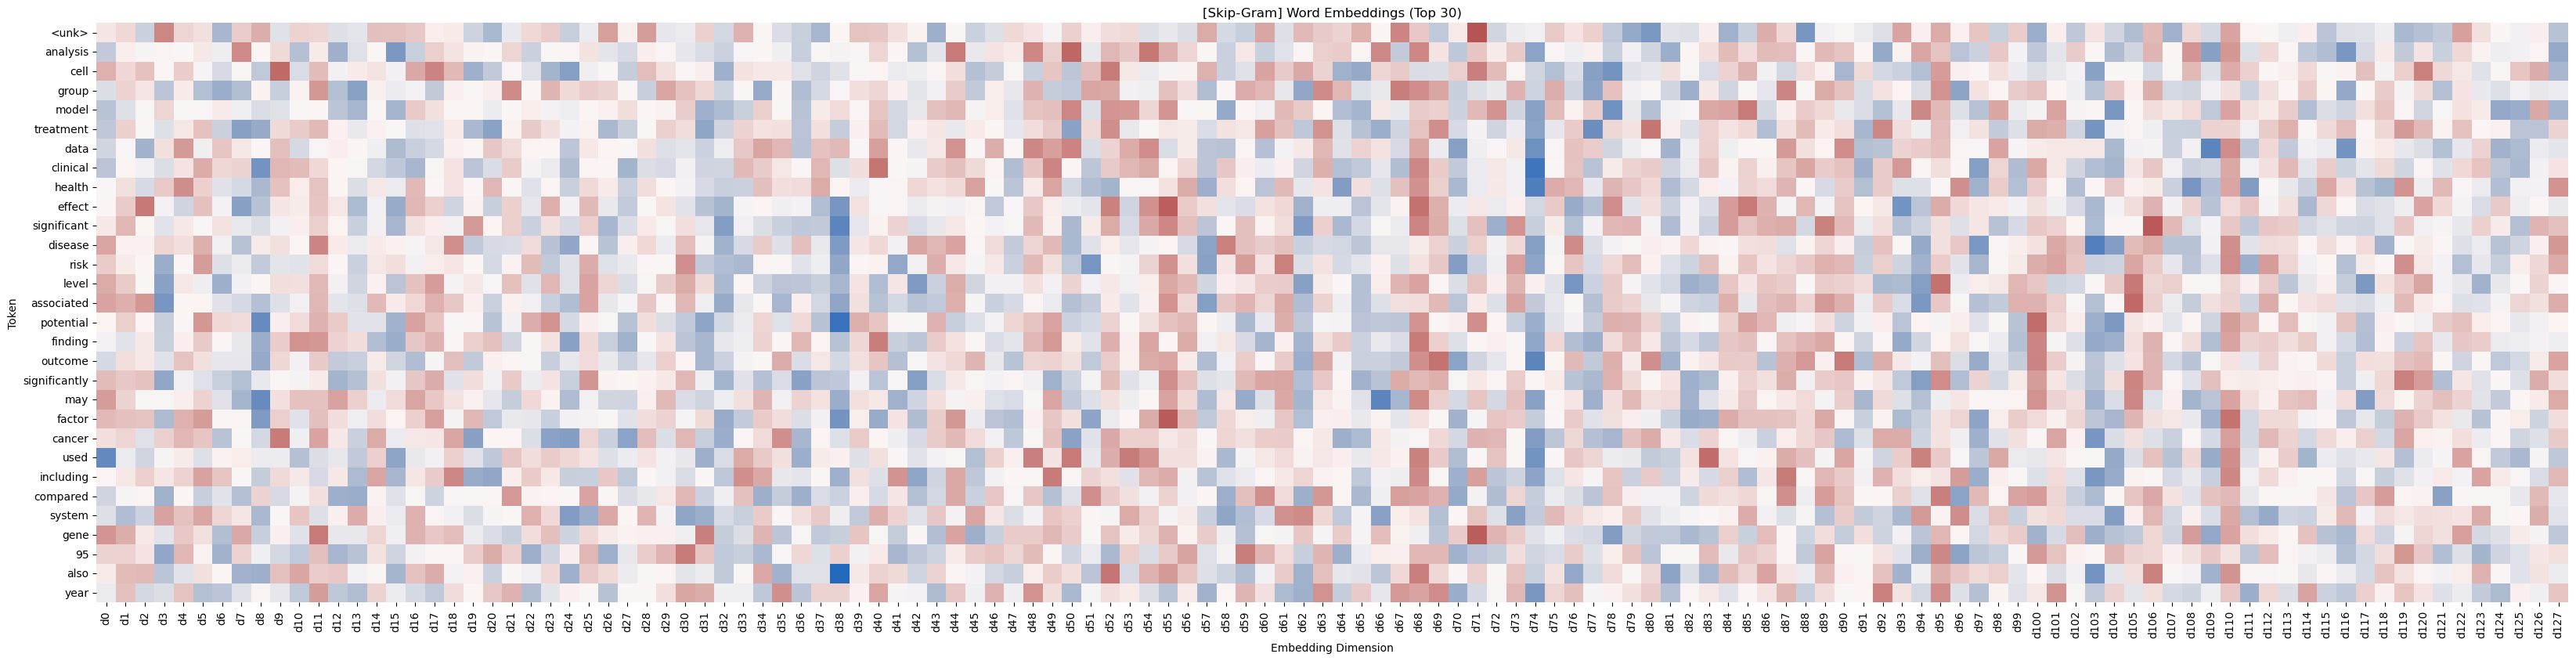

In [4]:
# =========================
# 7) 과제 3. 정성적 비교 분석 (모델 로드 및 시각화)
# =========================
print("과제 3단계: 정성적 비교 분석 시작...")

# --- 1. CBOW 모델 및 어휘 사전 로드 ---
print("--- 1. CBOW 모델 로드 중 ---")

cbow_datamodule = LemmaCBOWDataModule(
    df_all=df_preprocessed,
    min_freq=2,             
    max_vocab=None,         
    max_samples_per_doc=None, 
    device=DEVICE           
)
cbow_itos = cbow_datamodule.itos
pad_idx = cbow_datamodule.stoi['<pad>']

# (수정) 학습(Cell 50)과 동일하게 모델 뼈대 생성
cbow_model = CBOW(
    vocab_size=cbow_datamodule.vocab_size, 
    embed_dim=128,
    padding_idx=pad_idx,   # (수정) padding_idx 추가
    dropout_p=0.2          # (수정) dropout_p 추가
)
cbow_model.to(DEVICE) # 모델을 DEVICE로 이동

# 저장된 가중치 불러오기
try:
    
    cbow_model.load_state_dict(torch.load('best_cbow_model.pth')) 
    cbow_model.eval() # 평가 모드로 설정
    print("CBOW 모델('best_cbow_model.pth') 로드 성공.")
    
    # CBOW 임베딩 추출
    cbow_emb_matrix = cbow_model.emb.weight.detach().cpu()
    
    # CBOW 시각화
    visualize_embedding_heatmap(
        cbow_itos, 
        cbow_emb_matrix, 
        top_k=30, 
        title="[CBOW] Word Embeddings (Top 30)"
    )
    plt.show() # (수정) 함수 호출 '후'에 show() 호출

except FileNotFoundError:
    print("오류: 'best_cbow_model.pth' 파일을 찾을 수 없습니다. CBOW 학습을 먼저 실행하세요.")
except Exception as e:
    print(f"CBOW 모델 로드 중 오류 발생: {e}")


# --- 2. Skip-Gram 모델 및 어휘 사전 로드 ---
print("\n--- 2. Skip-Gram 모델 로드 중 ---")

sg_datamodule = LemmaSkipGramDataModule(
    df_all=df_preprocessed,
    min_freq=2,             
    max_vocab=None,        
    max_samples_per_doc=None, 
    device=DEVICE           
)
sg_itos = sg_datamodule.itos
sg_pad_idx = sg_datamodule.stoi['<pad>']


sg_model = SkipGram(
    vocab_size=sg_datamodule.vocab_size, 
    embed_dim=128,
    padding_idx=sg_pad_idx 
)
sg_model.to(DEVICE) 

# 저장된 가중치 불러오기
try:
    sg_model.load_state_dict(torch.load('best_skipgram_model.pth'))
    sg_model.eval() # 평가 모드로 설정
    print("Skip-Gram 모델('best_skipgram_model.pth') 로드 성공.")
    
    # Skip-Gram 임베딩 추출 (in_emb 사용)
    sg_emb_matrix = sg_model.in_emb.weight.detach().cpu()
    
    # Skip-Gram 시각화
    visualize_embedding_heatmap(
        sg_itos, 
        sg_emb_matrix, 
        top_k=30,
        title="[Skip-Gram] Word Embeddings (Top 30)" # (수정) title 인자 추가
    )
    plt.show() # (수정) 함수 호출 '후'에 show() 호출

except FileNotFoundError:
    print("오류: 'best_skipgram_model.pth' 파일을 찾을 수 없습니다. Skip-Gram 학습을 먼저 실행하세요.")
except Exception as e:
    print(f"Skip-Gram 모델 로드 중 오류 발생: {e}")


--- CBOW t-SNE (Top 100) ---


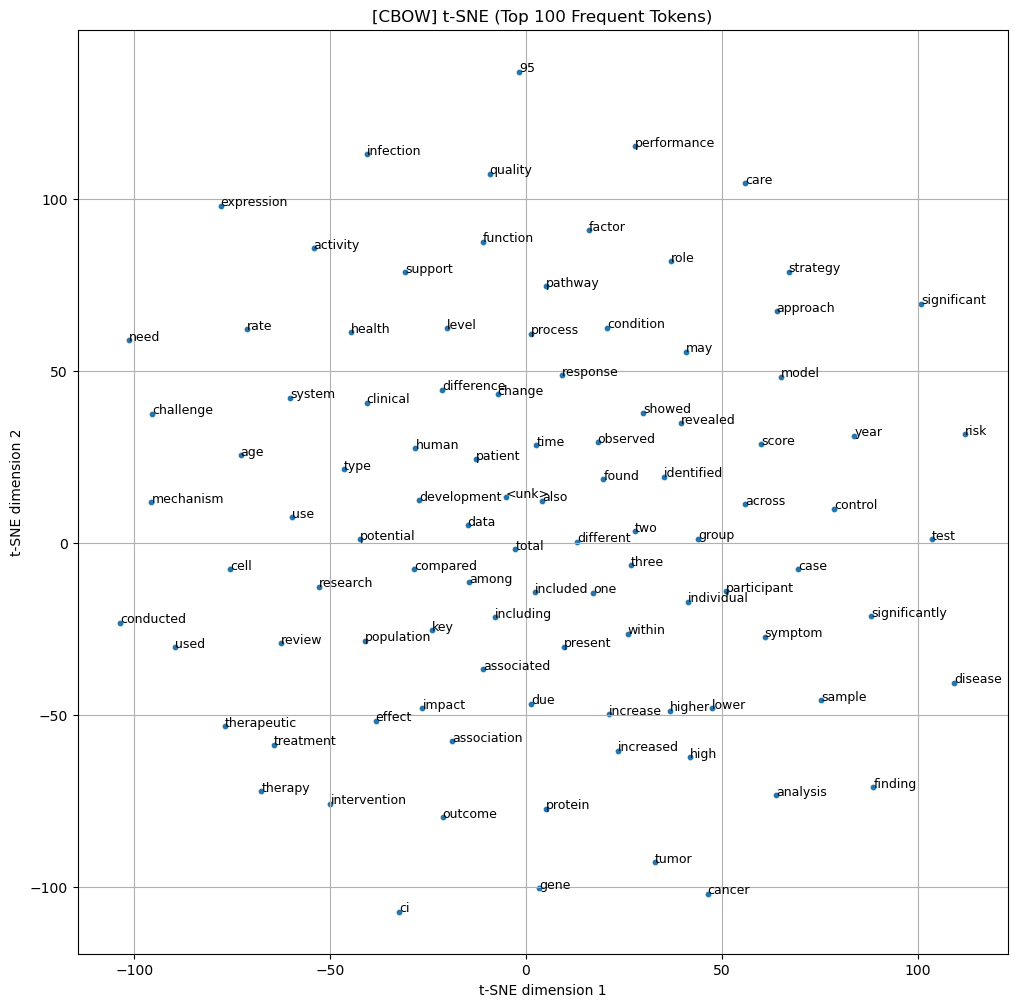


--- Skip-Gram t-SNE (Top 100) ---


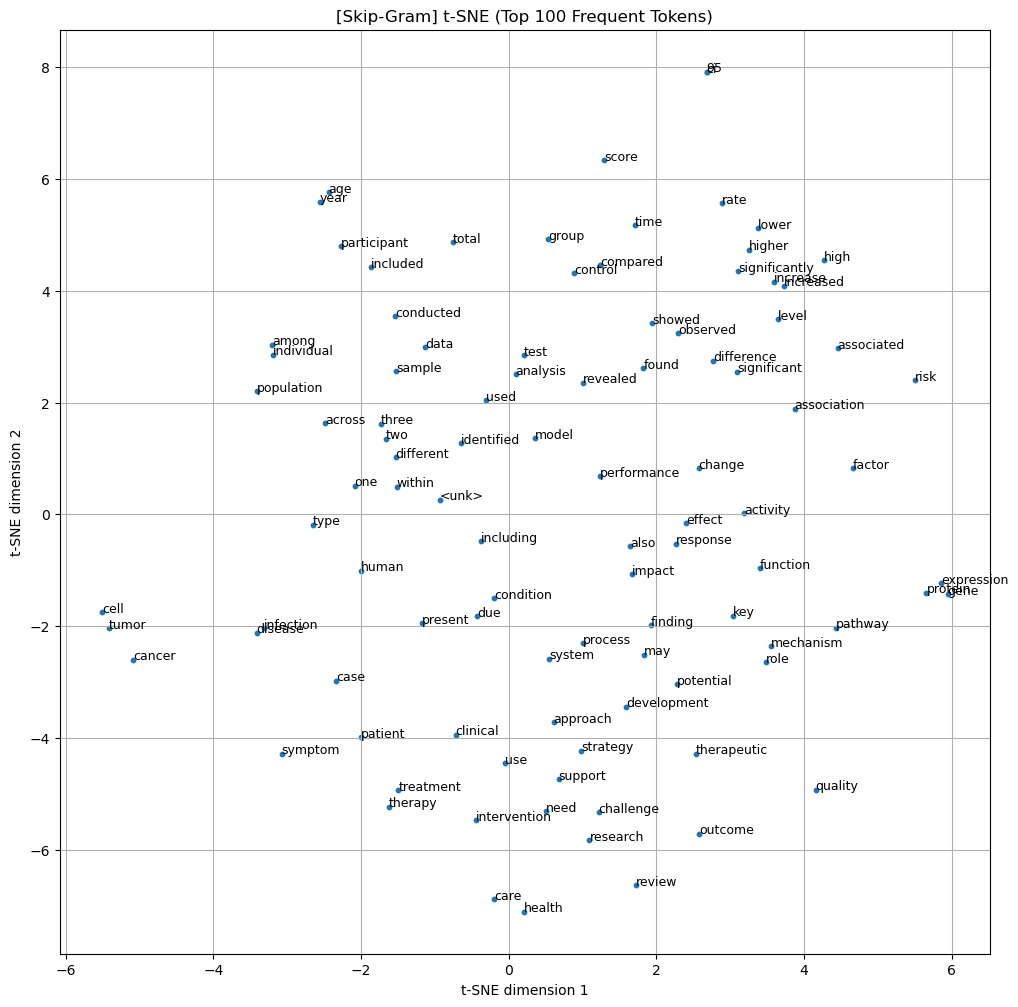

In [5]:
# =========================
# 7-2) t-SNE 시각화 함수 및 실행
# =========================
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from typing import Dict, List  # <--- [수정] NameError 방지를 위해 import 추가

def visualize_embedding_tsne(
    itos: Dict[int, str],
    emb_matrix: np.ndarray,
    target_tokens: List[str] = None,
    top_k: int = 100,
    perplexity: float = 30.0,
    random_state: int = 42,
    title: str = "t-SNE Visualization"
):
    """
    t-SNE를 사용하여 임베딩을 2D로 시각화합니다.
    """
    E = _ensure_numpy(emb_matrix) # (V, D)
    V, D = E.shape
    stoi = {tok: idx for idx, tok in itos.items()}
    
    # 1. 시각화 대상 인덱스 및 레이블 선정
    if target_tokens:
        idxs = [stoi[tok] for tok in target_tokens if tok in stoi]
        labels = [itos[i] for i in idxs]
        if not idxs:
            print("Warning: target_tokens에 해당하는 단어를 어휘사전에서 찾을 수 없습니다.")
            return
    else:
        # PAD(0) 제외, 상위 K개
        idxs = [i for i in range(V) if i != 0][:top_k]
        labels = [itos[i] for i in idxs]

    mat = E[idxs] # (N, D) - 대상 단어들의 임베딩 벡터

    # 2. t-SNE 실행
    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, len(labels) - 1), # Perplexity는 샘플 수보다 작아야 함
        random_state=random_state,
        init='pca',
        learning_rate='auto'
    )
    coords = tsne.fit_transform(mat) # (N, 2)

    # 3. DataFrame 생성
    df = pd.DataFrame({'x': coords[:, 0], 'y': coords[:, 1], 'label': labels})

    # 4. 시각화 (Scatter Plot)
    plt.figure(figsize=(12, 12))
    plt.scatter(df['x'], df['y'], s=10) # s=포인트 크기
    
    # 각 점에 단어 레이블 추가
    for i, row in df.iterrows():
        plt.annotate(row['label'], (row['x'], row['y']), fontsize=9)
        
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.grid(True)
    # plt.show() # <--- [수정] 이 줄을 삭제하거나 주석 처리합니다.

# --- 실행 코드 ---
# (가정: 이전 셀(Cell 52)에서 cbow_itos, cbow_emb_matrix, sg_itos, sg_emb_matrix가 로드됨)

print("\n--- CBOW t-SNE (Top 100) ---")
visualize_embedding_tsne(
    cbow_itos, 
    cbow_emb_matrix, 
    top_k=100, 
    title="[CBOW] t-SNE (Top 100 Frequent Tokens)"
)
plt.show() # <--- [수정] 그래프를 여기서 보여줍니다.

print("\n--- Skip-Gram t-SNE (Top 100) ---")
visualize_embedding_tsne(
    sg_itos, 
    sg_emb_matrix, 
    top_k=100, 
    title="[Skip-Gram] t-SNE (Top 100 Frequent Tokens)"
)
plt.show() # <--- [수정] 그래프를 여기서 보여줍니다.

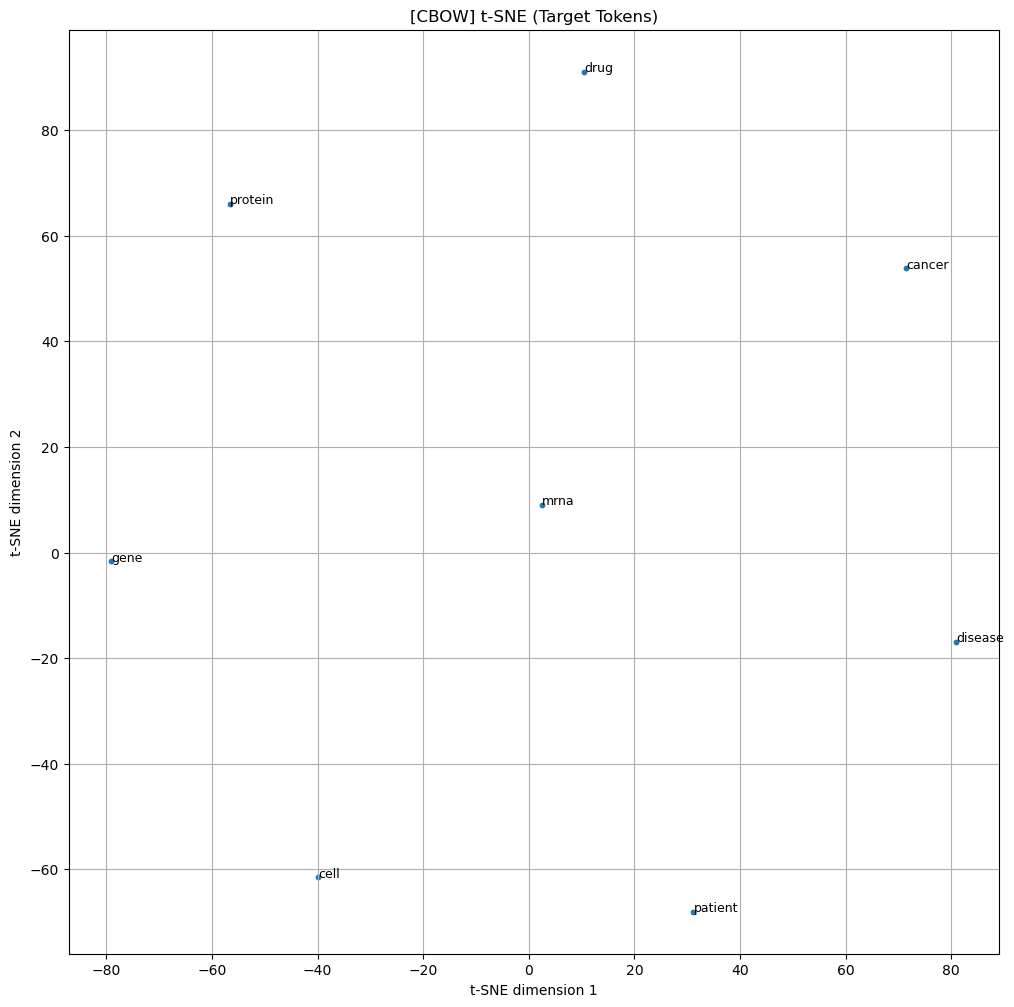

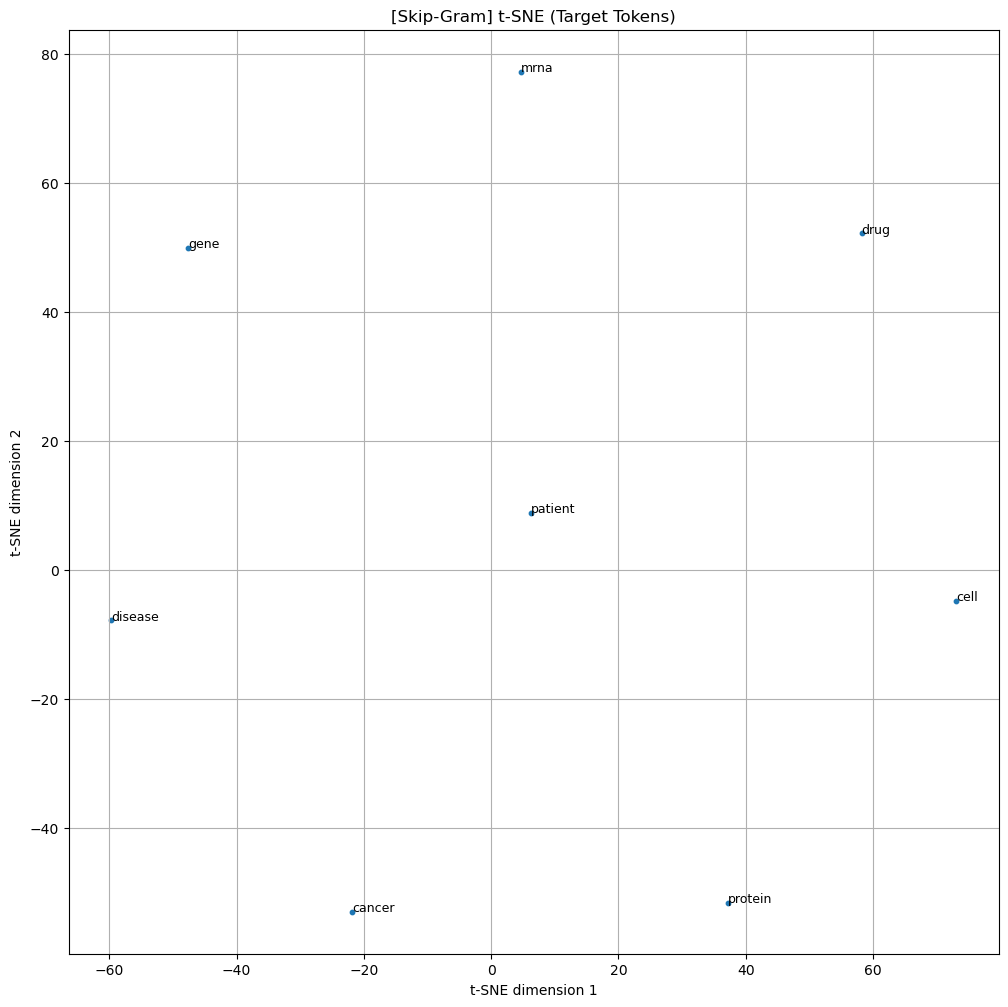

In [6]:
target_list = ['cell', 'protein', 'gene', 'disease', 'cancer', 'drug', 'mrna', 'patient']
visualize_embedding_tsne(cbow_itos, cbow_emb_matrix, target_tokens=target_list, title="[CBOW] t-SNE (Target Tokens)")
visualize_embedding_tsne(sg_itos, sg_emb_matrix, target_tokens=target_list, title="[Skip-Gram] t-SNE (Target Tokens)")

In [7]:
!pip -q install umap-learn


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip



--- CBOW UMAP & K-Means (Top 200, 10 Clusters) ---


/home/bmegpu03/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


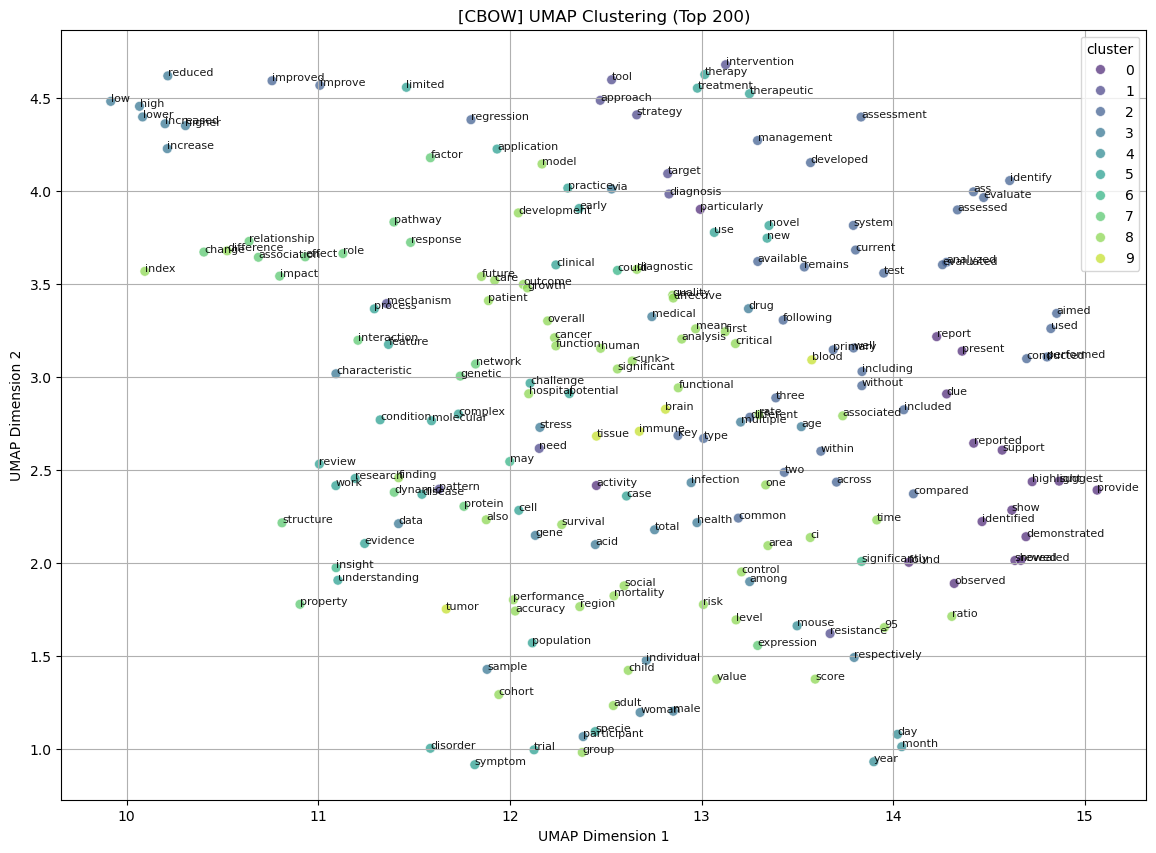


--- Skip-Gram UMAP & K-Means (Top 200, 10 Clusters) ---


/home/bmegpu03/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


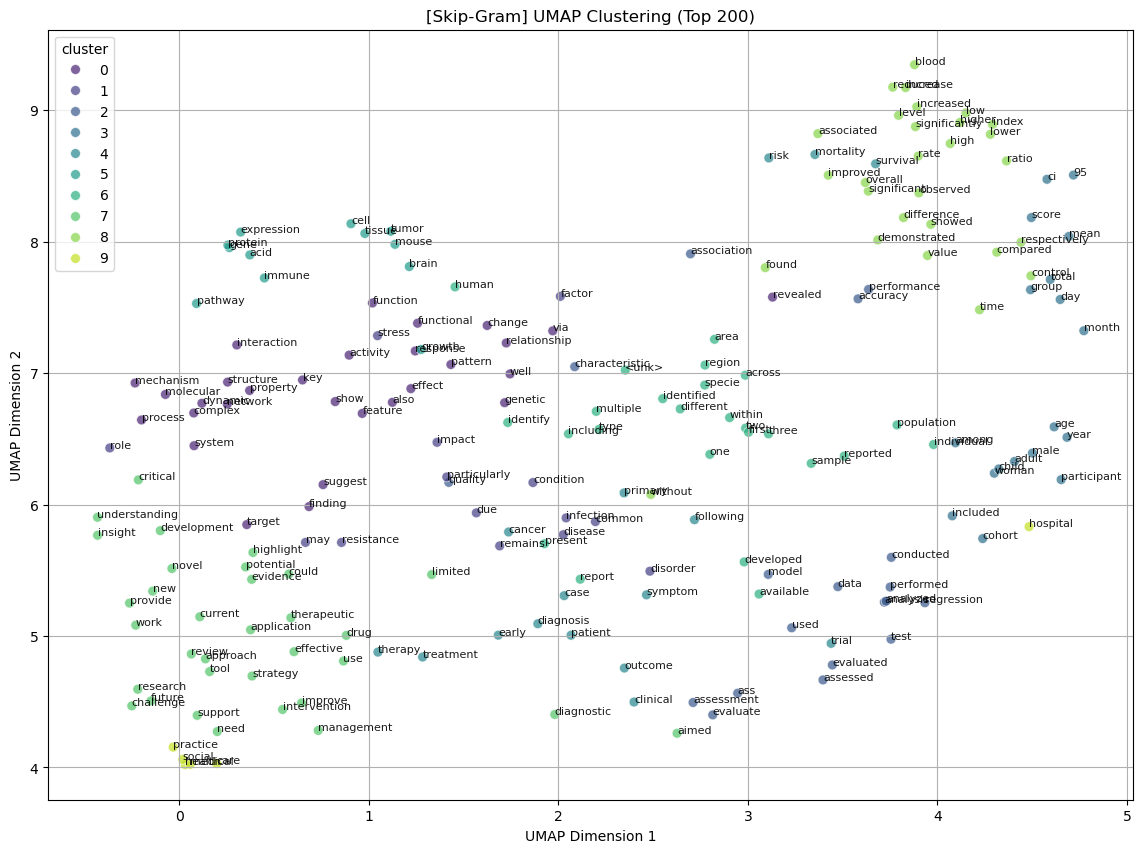

In [8]:
# =========================
# 7-3) UMAP 및 K-Means 시각화 함수
# =========================
import umap                   # UMAP 라이브러리
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List  # NameError 방지

def visualize_clusters_umap(
    itos: Dict[int, str],
    emb_matrix: np.ndarray,
    top_k: int = 200,          # 시각화할 단어 개수
    n_clusters: int = 10,      # K-Means로 찾을 군집 개수
    n_neighbors: int = 15,     # UMAP 파라미터 (낮으면 국소적, 높으면 전역적)
    min_dist: float = 0.1,     # UMAP 파라미터 (얼마나 촘촘히 모을지)
    random_state: int = 42,
    title: str = "UMAP Clustering"
):
    """
    UMAP 2D 축소 및 K-Means 클러스터링 동시 시각화
    """
    E = _ensure_numpy(emb_matrix) # (V, D)
    V, D = E.shape
    
    # 1. 시각화 대상 선정 (PAD=0 제외, 빈도 상위 K개)
    idxs = [i for i in range(V) if i != 0][:top_k]
    labels = [itos[i] for i in idxs]
    # (N, 128) - 대상 단어들의 원본 128차원 벡터
    mat = E[idxs] 

    # 2. K-Means 클러스터링 실행 (원본 128D 벡터 기준)
    # (중요!) 2D로 축소된 좌표가 아닌, 원본 벡터로 군집화해야
    # 의미론적으로 더 정확한 그룹을 찾을 수 있습니다.
    kmeans = KMeans(
        n_clusters=n_clusters, 
        random_state=random_state, 
        n_init=10  # 경고 메시지 방지
    )
    # 각 단어가 몇 번 클러스터에 속하는지 라벨링 (예: 0, 1, ..., 9)
    cluster_labels = kmeans.fit_predict(mat) 

    # 3. UMAP 실행 (2D 축소)
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2, # 2차원
        random_state=random_state
    )
    # 128차원 벡터 -> 2차원 좌표로 변환
    coords = reducer.fit_transform(mat) # (N, 2)

    # 4. DataFrame 생성
    df = pd.DataFrame({
        'x': coords[:, 0], 
        'y': coords[:, 1], 
        'label': labels, 
        'cluster': pd.Categorical(cluster_labels) # 색상 구분을 위해 범주형으로
    })

    # 5. 시각화 (Scatter Plot)
    plt.figure(figsize=(14, 10))
    # 클러스터별로 색상을 다르게(hue)하여 점을 찍음
    sns.scatterplot(
        data=df,
        x='x',
        y='y',
        hue='cluster', # K-Means 결과를 색상으로 매핑
        palette='viridis', # 'tab10', 'Paired' 등 다양한 색상표 사용 가능
        legend='full',
        s=50, 
        alpha=0.7
    )
    
    # 각 점에 단어 레이블 추가 (top_k가 200개라 다소 겹칠 수 있음)
    for i, row in df.iterrows():
        plt.annotate(row['label'], (row['x'], row['y']), fontsize=8, alpha=0.9)
        
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(True)
    # plt.show()는 함수 밖에서 호출

# =========================
# 7-4) UMAP 실행
# =========================

# (가정: 이전 셀(Cell 52)에서 cbow_itos, cbow_emb_matrix, sg_itos, sg_emb_matrix가 로드됨)

print("\n--- CBOW UMAP & K-Means (Top 200, 10 Clusters) ---")
visualize_clusters_umap(
    cbow_itos, 
    cbow_emb_matrix, 
    top_k=200, 
    n_clusters=10, 
    title="[CBOW] UMAP Clustering (Top 200)"
)
plt.show()

print("\n--- Skip-Gram UMAP & K-Means (Top 200, 10 Clusters) ---")
visualize_clusters_umap(
    sg_itos, 
    sg_emb_matrix, 
    top_k=200, 
    n_clusters=10, 
    title="[Skip-Gram] UMAP Clustering (Top 200)"
)
plt.show()

## Post Mid-term Assignment

### 과제 개요

**제출 기한**: 11월 5일 화요일 23:59  
**제출 형식**: E-Class 업로드

- 레포트: `BME_BioNLP_과제2_{이름}_{학번}.pdf`
    - 2 페이지 이내 (참고 문헌 섹션을 제외한 기준)
    - Reference (참고 문헌 및 인용 표시) 선택
    - 무조건 pdf 형식
- 분석 코드가 있는 노트북: `BME_BioNLP_과제2_{이름}_{학번}.ipynb`

---

### 과제 목표
- Word2Vec 모델 중 CBOW 코드 베이스를 바탕으로 Skip-Gram을 구현하여 모델 학습 및 CBOW와의 비교 분석을 진행합니다.

---

### 과제 수행 단계
1. **Skip-Gram 구현**
    - **Step 1. Skip-Gram 맞품형 Data 관련 모듈 구현 **
        - 실습 수업 시간에 사용했던 동일한 데이터셋을 활용합니다.
        - Skip-Gram의 학습 Task를 이해하여 그것에 맞는 데이터 전처리 방법을 고안합니다.
        - ***온라인 강의에서 언급한 Negative Sampling 구현합니다.***
    - **Step 2. Skip-Gram 모델 구현**
        - 구현한 CBOW 모델 클래스 재사용 권장합니다.

2. **Skip-Gram 학습 진행**
    - 구현한 Trainer 클래스 재사용 권장합니다.

3. **정성적 비교 분석 진행 (CBOW vs Skip-Gram)**
    - 각 Word2Vec 모델로부터 Word Vector Embedding을 추출하여 시각화 합니다.
    - 시각화한 결과에 대해 추가적인 분석을 자율적으로 진행합니다 (UMAP, t-SNE, 군집화 등).
    - 두 모델이 예측하는 단어들의 경향성에 대한 분석을 자율적으로 진행합니다.

4. **보고서 작성**
    - CBOW와 Skip-Gram의 구현 차이를 정리합니다.
        - 데이터 샘플링(문맥→중심 vs 중심→문맥), 모델 파라미터 구성(입·출력 임베딩 분리 여부), 손실 설계(평균 집계 vs 네거티브 샘플링), 연산 복잡도·학습 속도 관점에서 핵심 차이를 간결히 서술합니다.
    - 두 모델에서 얻은 워드 임베딩 정성 분석
        - 시각화를 통해 의미적 근접성·군집 경향을 평가하고, 도메인 용어 표현력 및 오류 사례를 해석합니다.

        

In [75]:
!pip -q install umap-learn


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [27]:

# =========================
# 7-3) UMAP 및 K-Means 시각화 함수
# =========================
import umap # UMAP 임포트
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List

def visualize_clusters_umap(
    itos: Dict[int, str],
    emb_matrix: np.ndarray,
    top_k: int = 200,
    n_clusters: int = 10,  # K-Means 클러스터 개수
    n_neighbors: int = 15, # UMAP 파라미터
    min_dist: float = 0.1, # UMAP 파라미터
    random_state: int = 42,
    title: str = "UMAP Clustering"
):
    """
    UMAP 2D 축소 및 K-Means 클러스터링 동시 시각화
    """
    E = _ensure_numpy(emb_matrix) # (V, D)
    V, D = E.shape
    stoi = {tok: idx for idx, tok in itos.items()}
    
    # 1. 시각화 대상 선정 (PAD=0 제외, 상위 K개)
    idxs = [i for i in range(V) if i != 0][:top_k]
    labels = [itos[i] for i in idxs]
    mat = E[idxs] # (N, D) - 대상 단어들의 원본 128차원 벡터

    # 2. UMAP 실행 (2D 축소)
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=random_state
    )
    coords = reducer.fit_transform(mat) # (N, 2)

    # 3. K-Means 클러스터링 실행
    # (참고: 2D 축소된 coords가 아닌, 원본 128D 벡터 'mat'을 기준으로 군집화)
    kmeans = KMeans(
        n_clusters=n_clusters, 
        random_state=random_state, 
        n_init=10
    )
    cluster_labels = kmeans.fit_predict(mat) # (N,)

    # 4. DataFrame 생성
    df = pd.DataFrame({
        'x': coords[:, 0], 
        'y': coords[:, 1], 
        'label': labels, 
        'cluster': cluster_labels
    })

    # 5. 시각화 (Scatter Plot)
    plt.figure(figsize=(14, 10))
    # 클러스터별로 색상 지정
    sns.scatterplot(
        data=df,
        x='x',
        y='y',
        hue='cluster', # 클러스터 ID에 따라 색상 매핑
        palette='viridis', # 'viridis', 'tab10' 등
        legend='full',
        s=50, # 점 크기
        alpha=0.7
    )
    
    # 각 점에 단어 레이블 추가 (선택적)
    # K=200개는 너무 많아 보일 수 있으므로, 주석 처리하거나 K를 줄이세요.
    for i, row in df.iterrows():
        plt.annotate(row['label'], (row['x'], row.y), fontsize=8, alpha=0.9)
        
    plt.title(title)
    plt.xlabel("UMAP dimension 1")
    plt.ylabel("UMAP dimension 2")
    plt.grid(True)
    plt.show()

In [28]:
# =========================
# 7-4) UMAP 실행
# =========================

# (필요시) CBOW 모델 로드
# cbow_datamodule = LemmaCBOWDataModule(df_preprocessed, min_freq=2)
# cbow_itos = cbow_datamodule.itos
# cbow_model = CBOW(vocab_size=cbow_datamodule.vocab_size, embed_dim=128)
# cbow_model.load_state_dict(torch.load('cbow_best_model.pt'))
# cbow_emb_matrix = cbow_model.emb.weight.detach().cpu()

# (필요시) Skip-Gram 모델 로드
# sg_datamodule = LemmaSkipGramDataModule(df_preprocessed, min_freq=2)
# sg_itos = sg_datamodule.itos
# sg_model = SkipGram(vocab_size=sg_datamodule.vocab_size, embed_dim=128)
# sg_model.load_state_dict(torch.load('skipgram_best_model.pt'))
# sg_emb_matrix = sg_model.in_emb.weight.detach().cpu()


print("\n--- CBOW UMAP & K-Means (Top 200, 10 Clusters) ---")
visualize_clusters_umap(
    cbow_itos, 
    cbow_emb_matrix, 
    top_k=200, 
    n_clusters=10, 
    title="[CBOW] UMAP Clustering (Top 200)"
)

print("\n--- Skip-Gram UMAP & K-Means (Top 200, 10 Clusters) ---")
visualize_clusters_umap(
    sg_itos, 
    sg_emb_matrix, 
    top_k=200, 
    n_clusters=10, 
    title="[Skip-Gram] UMAP Clustering (Top 200)"
)


--- CBOW UMAP & K-Means (Top 200, 10 Clusters) ---


NameError: name 'cbow_itos' is not defined